# Example NTA-A "3D Truss System"

This example describes a three-dimensional system of trusses with 5 Nodes and 6 Elements (in total 5 active DOF). Given to it's geometry strong geometric nonlinearities are to be excepted when the given reference load is applied. The model is shown in different views: a general 3D-view and views in XZ-,YZ- and XY-planes. The force vectors of the reference load are illustrated in green, where the force scale is denoted separated on each figure. Within the 3D-view the coordinate system is indicated as a black tripod with a big black dot at the origin point. The XY-plane is illustrated with a semi-transparent light blue fill.

[![MyBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/adtzlr/trusspy/main?labpath=docs%2Fexamples%2FeNTA%2DA%2FeNTA%2DA.ipynb)
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adtzlr/trusspy/blob/main/docs/examples/eNTA-A/eNTA-A.ipynb)

## Model creation

First we import trusspy with it's own namespace and create a Model object `M`. By explicitly enforcing a logfile creation all incremental solution informations are stored in a file `analysis.log` instead of printing it to the interactive shell window.

In [ ]:
!pip install trusspy

In [2]:
import trusspy as tp

M = tp.Model(logfile=True)

Now we create Nodes with coordinate triples and Elements with a list of node connectivities and both material and geometric properties. Both Nodes and Elements are identified with their label. To keep the code clean we'll use the `with` statement for the model creation process.

In [3]:
with M.Nodes as MN:
    MN.add_node(1, coord=(2.5, 0, 0))
    MN.add_node(2, coord=(-1.25, 1.25, 0))
    MN.add_node(3, coord=(1, 2, 0))
    MN.add_node(4, coord=(-0.5, 1.5, 1.5))
    MN.add_node(5, coord=(-2.5, 4.5, 2.5))

In [4]:
element_type = 1  # truss
material_type = 1  # linear-elastic

youngs_modulus = 1.0

In [5]:
with M.Elements as ME:
    ME.add_element(1, conn=(1, 4), gprop=[0.75])
    ME.add_element(2, conn=(2, 4), gprop=[1])
    ME.add_element(3, conn=(3, 4), gprop=[0.5])
    ME.add_element(4, conn=(3, 5), gprop=[0.75])
    ME.add_element(5, conn=(2, 5), gprop=[1])
    ME.add_element(6, conn=(4, 5), gprop=[1])

    ME.assign_etype("all", element_type)
    ME.assign_mtype("all", material_type)
    ME.assign_material("all", [youngs_modulus])

Beside Nodes and Elements we have to define Mechanical (U) Boundaries and External Forces. If a node does not contain Boundaries or External Forces the corresponding entries are added automatically by TrussPy.

In [6]:
with M.Boundaries as MB:
    MB.add_bound_U(1, (0, 0, 0))
    MB.add_bound_U(2, (0, 0, 0))
    MB.add_bound_U(3, (0, 0, 0))
    MB.add_bound_U(5, (1, 0, 1))

with M.ExtForces as MF:
    MF.add_force(4, (1, 1, -1))
    MF.add_force(5, (-2, 0, -2))

Now that the model is finished some additional Settings have to be chosen. Initial allowed incremental system vector components for both the displacement vector and the load-proportionality-factor have to be specified. We use `dlpf = 0.005` and `du = 0.05` (figured out after some trial and error). Both parameters can't be specified automatically as they depend on the model configuration. The job will be limited to a total amount of 190 increments (again, the total number has been figured out after some job runs to get good looking plots).

In [7]:
M.Settings.dlpf = 0.005
M.Settings.du = 0.05
M.Settings.incs = 163

To speed up the calculation and make the model solution process more robust against a poorly defined initinal incremental system vector an automatic incremental step-size control is activated (`stepcontrol = True`). A maximum factor of `maxfac = 4` limits the increase of the incremental values. If the solution converges but the incremental system vector is bigger than the one specified a total overshoot factor of `dxtol = 1.25` is allowed.

In [8]:
M.Settings.stepcontrol = True
M.Settings.maxfac = 4

M.Settings.ftol = 8
M.Settings.xtol = 8
M.Settings.nfev = 8

M.Settings.dxtol = 1.25

## Build & Run the Model

As the Model creation is finished we may start the calculation process by calling the two Model methods `build()` and `run()`. During the build process the model components will be sorted according to their label. Missing entries (e.g. nodes with zero external force vector) are automatically added. The `run()` method finally starts the calculation.


# Model Summary
Analysis Dimension      "ndim": 3
Number of Nodes       "nnodes": 5
Number of Elements    "nelems": 6
 
System DOF              "ndof": 15
active DOF             "ndof1": 5
locked DOF             "ndof2": 10
 
active DOF          "nproDOF1": [ 9 10 11 12 14]
fixed  DOF          "nproDOF0": [ 0  1  2  3  4  5  6  7  8 13]


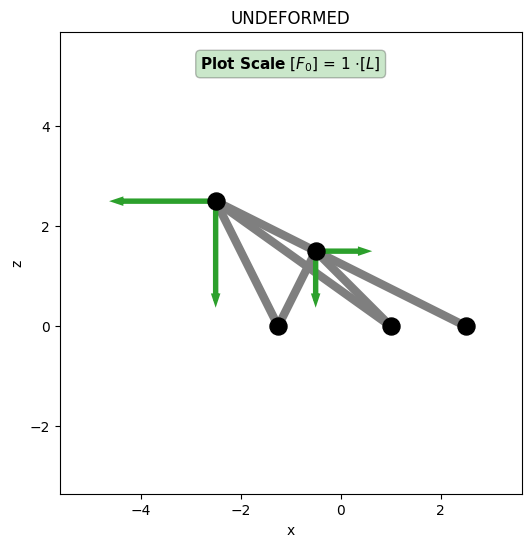

In [37]:
M.build()
fig, ax = M.plot_model(inc=0)

In [10]:
M.run()

## Verify the Results

After the job has finished the logfile contains useful information regarding convergence, recycles and control components. At the end of the logfile the total execution time during the `run()` method was measured.

```
# LOGFILE "analysis.log"

total  cpu time "build":      0.001 seconds
total wall time "build":      0.000 seconds

total  cpu time "run":        1.546 seconds
total wall time "run":        1.547 seconds
```

For example at increment 40 a converged solution was obtained within 4 iterations plus one iteration to get the new control component. The determination of the control component is based on a linear solution (only 1 Newton-Rhapson iteration) for the current allowed incremental LPF. The sign of this allowed incremental LPF is estimated with the sign of the determinant of the stiffness matrix `det(KT)`. The vector norm of the equilibrium equations and the incremental system vector both satisfy the specified tolerance `tol = 1e-8` at the end of the increment. The 5th component of the incremental system vector (+DOF 5) is used as control component for the path tracing algorithm. No overshoot is detected - the control equation was fullfilled. The 2nd biggest displacement is +DOF 4 with a relative displacement of `-0.2549` compared to the allowed value. The final LPF at the end of increment 40 is given in the last line of the output.

```
### Increment 40
|Cycle|NR-It.|Control| Norm(g) |i(1)|Value   |i(2)|Value   |i(3)|Value   |
|:---:|:----:|:-----:|:-------:|:--:|:------:|:--:|:------:|:--:|:------:|
|  1  |   0  |   5   |2.421e-03|   5|       1|    |        |    |        |

|Cycle|NR-It.|Control| Norm(g) |i(1)|Value   |i(2)|Value   |i(3)|Value   |
|:---:|:----:|:-----:|:-------:|:--:|:------:|:--:|:------:|:--:|:------:|
|     |   1  |       |3.219e-06|    |        |    |        |    |        |
|     |   2  |       |1.356e-11|    |        |    |        |    |        |
|     |   3  |       |3.641e-16|    |        |    |        |    |        |
|total| sum  | used  |  final  |    | final  |    | final  |    | final  |
|  1  |   4  |   5   |3.641e-16|   5|  1.0000|   4| -0.2549|   3|  0.1940|

* final LPF:   -0.00268
```

In addition to the biggest components of the relative incremental system vector the Result object inside the Model also contains the absolute values. The results are printed below.

In [11]:
M.Results.R[40].U - M.Results.R[39].U

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.00249599,  0.00798939,  0.0387971 ],
       [-0.05098552,  0.        ,  0.2       ]])

In [12]:
M.Results.R[40].Ured - M.Results.R[39].Ured

array([-0.00249599,  0.00798939,  0.0387971 , -0.05098552,  0.2       ])

In [13]:
M.Results.R[40].dVmax

array([0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.02])

With this information at hand it is shown that DOF 5 is the biggest incremental displacement component (in positive direction). The total displacement vector and LPF factor for increment 40 is accesible via the Model Result:

In [14]:
M.Results.R[40].lpf

-0.0026801842402347288

In [15]:
M.Results.R[40].U

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.03645592,  1.22726375, -1.62247931],
       [-1.1481524 ,  0.        , -3.20556769]])

In [16]:
M.Results.R[40].Ured

array([-0.03645592,  1.22726375, -1.62247931, -1.1481524 , -3.20556769])

The element forces for increment 40 are

In [17]:
M.Results.R[40].element_force

array([[ 0.08349248],
       [-0.02975494],
       [-0.10900865],
       [ 0.05273887],
       [-0.04349102],
       [-0.03027099]])

and the corresponding strains in the elements are evaluated with the stretches:

In [18]:
M.Results.R[40].stretch - 1

array([[ 0.11132331],
       [-0.02975494],
       [-0.21801729],
       [ 0.07031849],
       [-0.04349102],
       [-0.03027099]])

The system equilibrium equations are displayed for the whole system and are reshaped to `(nnodes,ndim)`.

In [19]:
M.Results.R[40].g.reshape(M.nnodes, M.ndim)

array([[-6.20879115e-02,  5.57657066e-02, -2.50439479e-03],
       [ 1.25318172e-02, -6.11918787e-02,  9.69927407e-03],
       [ 5.22362786e-02, -2.17555888e-02,  8.45673437e-04],
       [-2.48499138e-16,  2.59774841e-16, -3.85975973e-17],
       [ 3.55618313e-17,  2.45015767e-02,  2.34187669e-17]])

If we take only the active DOF from this vector and plot it as flattened array it is shown that the equilibrium is fullfilled. Another check is performed with the interal force and external force vector at increment 40, which shows the same result as `g`.

In [20]:
M.Results.R[40].g.take(M.nproDOF1)

array([-2.48499138e-16,  2.59774841e-16, -3.85975973e-17,  3.55618313e-17,
        2.34187669e-17])

In [21]:
(-M.Results.R[40].r + M.Results.R[40].lpf * M.ExtForces.forces).take(M.nproDOF1)

array([-2.48499138e-16,  2.59774841e-16, -3.85975973e-17,  3.55618313e-17,
        2.34187669e-17])

## Model Plot and Node History
   
To visualize the deformed state of the model for increment 40 some model plots are generated. First the undeformed configuration is generated for different views.

<Figure size 640x480 with 0 Axes>

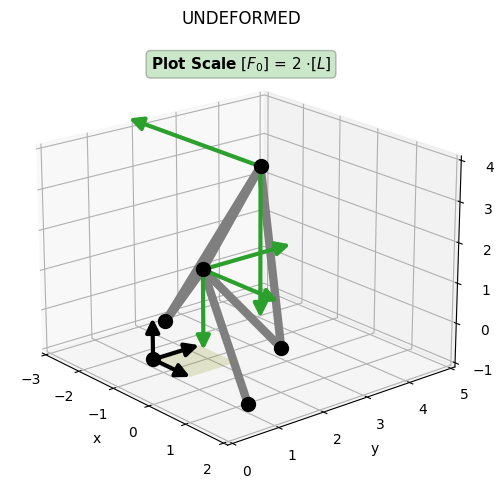

In [26]:
fig, ax = M.plot_model(
    view="3d",
    contour="force",
    lim_scale=(-3, 2, 0, 5, -1, 4),
    force_scale=2.0,
    inc=0,
)
fig.savefig("model_undeformed_inc0_3d.pdf")
fig.savefig("model_undeformed_inc0_3d.png")

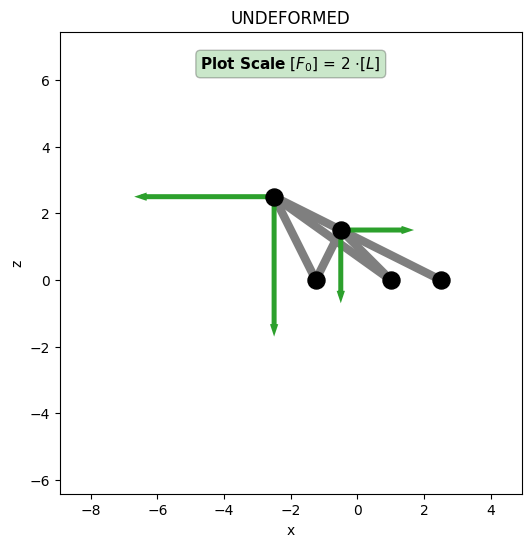

In [27]:
fig, ax = M.plot_model(
    view="xz",
    contour="force",
    lim_scale=1.4,
    force_scale=2.0,
    inc=0,
)
fig.savefig("model_undeformed_inc0_xz.pdf")
fig.savefig("model_undeformed_inc0_xz.png")

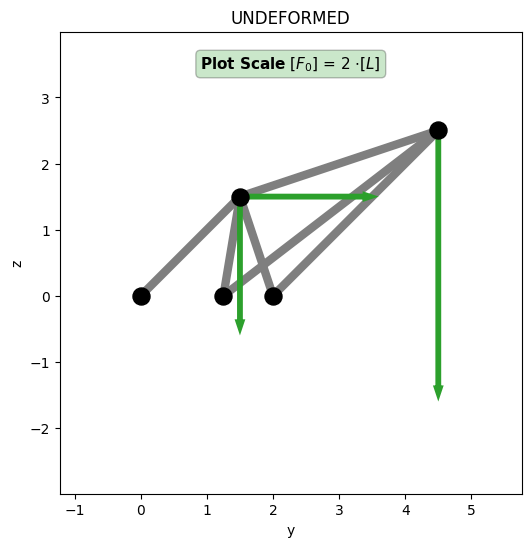

In [28]:
fig, ax = M.plot_model(
    view="yz",
    contour="force",
    lim_scale=1.4,
    force_scale=2.0,
    inc=0,
)
fig.savefig("model_undeformed_inc0_yz.pdf")
fig.savefig("model_undeformed_inc0_yz.png")

For the deformed model the figures are generated with the following code:

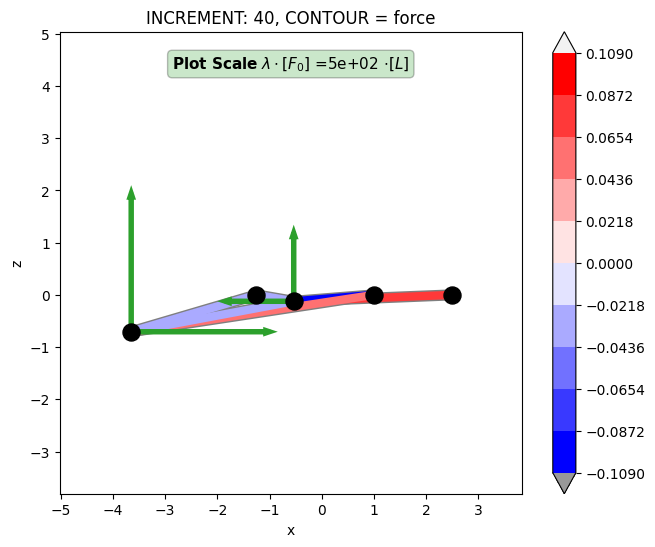

In [29]:
pinc = 40  # 105
fig, ax = M.plot_model(
    view="xz",
    contour="force",
    # lim_scale=(-4,4,-2,6,-1,5),
    lim_scale=1.3,
    force_scale=500.0,
    inc=pinc,
)
fig.savefig("model_contour-force_inc40_xz.pdf")
fig.savefig("model_contour-force_inc40_xz.png")

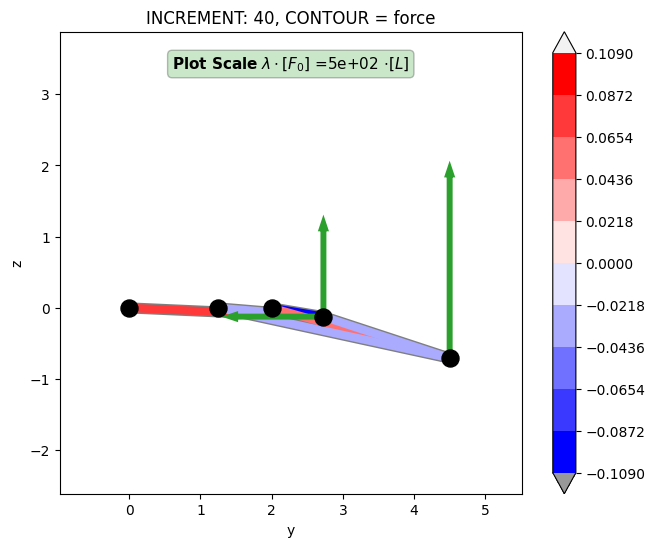

In [30]:
fig, ax = M.plot_model(
    view="yz",
    contour="force",
    # lim_scale=(-4,4,-2,6,-1,5),
    lim_scale=1.3,
    force_scale=500.0,
    inc=pinc,
)
fig.savefig("model_contour-force_inc40_yz.pdf")
fig.savefig("model_contour-force_inc40_yz.png")

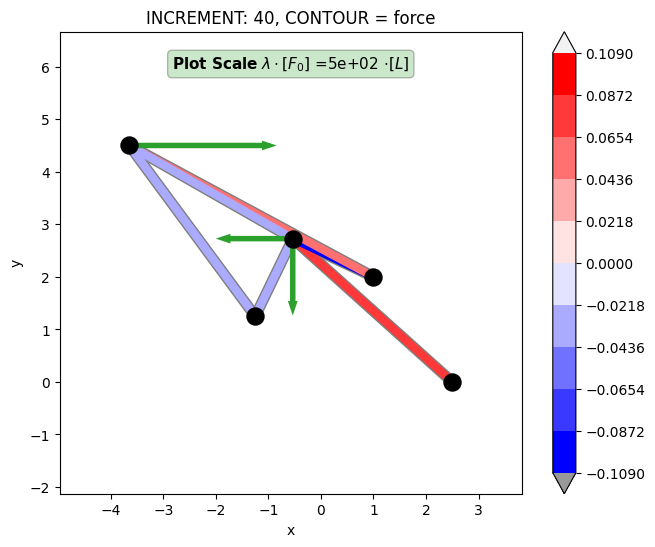

In [31]:
fig, ax = M.plot_model(
    view="xy",
    contour="force",
    # lim_scale=(-4,4,-2,6,-1,5),
    lim_scale=1.3,
    force_scale=500.0,
    inc=pinc,
)
fig.savefig("model_contour-force_inc40_xy.pdf")
fig.savefig("model_contour-force_inc40_xy.png")

<Figure size 640x480 with 0 Axes>

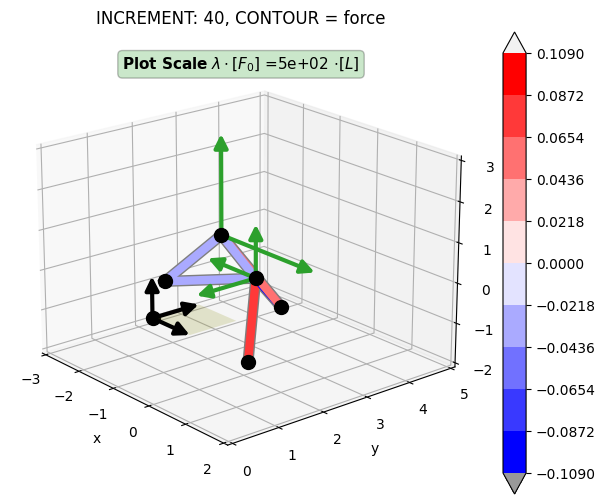

In [32]:
fig, ax = M.plot_model(
    view="3d",
    contour="force",
    lim_scale=(-3, 2, 0, 5, -2, 3),
    # lim_scale=1.2,
    force_scale=500.0,
    inc=pinc,
)
fig.savefig("model_contour-force_inc40_3d.pdf")
fig.savefig("model_contour-force_inc40_3d.png")

## Animation of the Deformation Process

The evolution of the deformation process is visualized with the help of an animated GIF file.

In [33]:
M.plot_movie(
    view="3d",
    contour="force",
    lim_scale=(-3, 2, 0, 5, -2, 3),  # 3D
    # lim_scale=-5, #XZ
    # lim_scale=(-4,4,-2,6), #XY
    # lim_scale=(-2,6,-2,6), #YZ
    cbar_limits=[-0.3, 0.3],
    force_scale=50.0,
    incs=range(0, M.Settings.incs, 1),
)

![Movie](figures/gif/movie.gif)

## Path-Tracing of the Displacement-LPF curves

The path-tracing of the deformation process is shown as a History Plot of Displacement-LPF curves for all active DOF. Strong geometrical nonlinearities are observed for all active DOF.

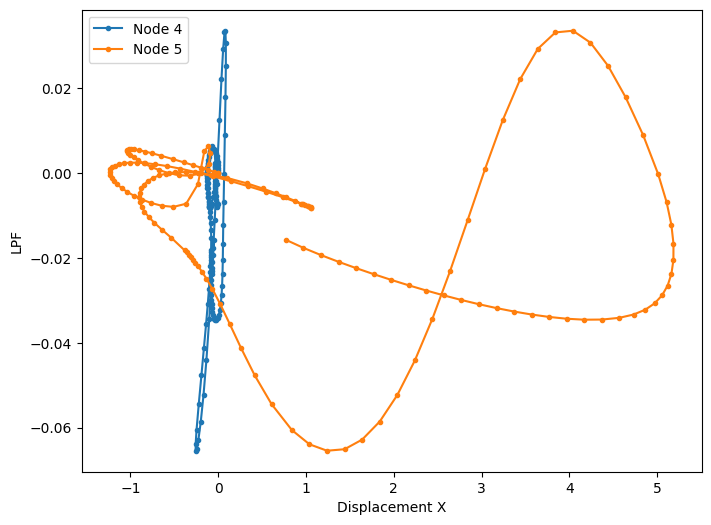

In [34]:
Disp = "Displacement X"
fig, ax = M.plot_history(nodes=[4, 4], X=Disp, Y="LPF")
fig, ax = M.plot_history(nodes=[5, 5], X=Disp, Y="LPF", fig=fig, ax=ax)
fig.savefig("history_node45_Disp" + Disp[-1] + "-LPF.pdf")
fig.savefig("history_node45_Disp" + Disp[-1] + "-LPF.png")

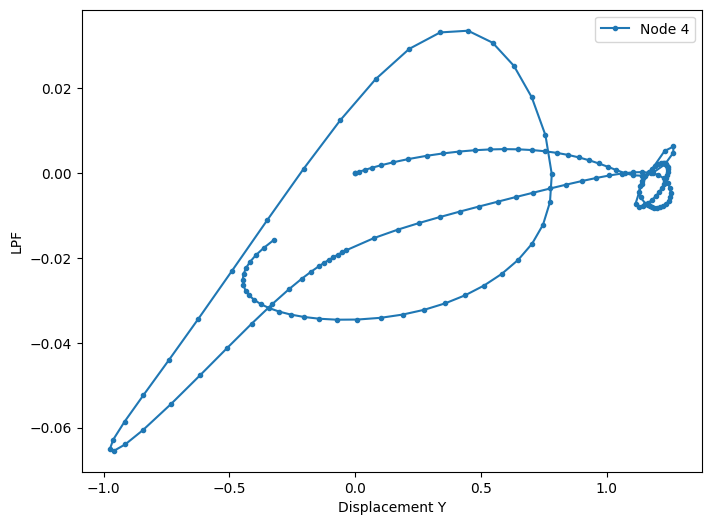

In [35]:
Disp = "Displacement Y"
fig, ax = M.plot_history(nodes=[4, 4], X=Disp, Y="LPF")
# fig,ax = M.plot_history(nodes=[5,5],X=Disp,Y='LPF',fig=fig,ax=ax)
fig.savefig("history_node45_Disp" + Disp[-1] + "-LPF.pdf")
fig.savefig("history_node45_Disp" + Disp[-1] + "-LPF.png")

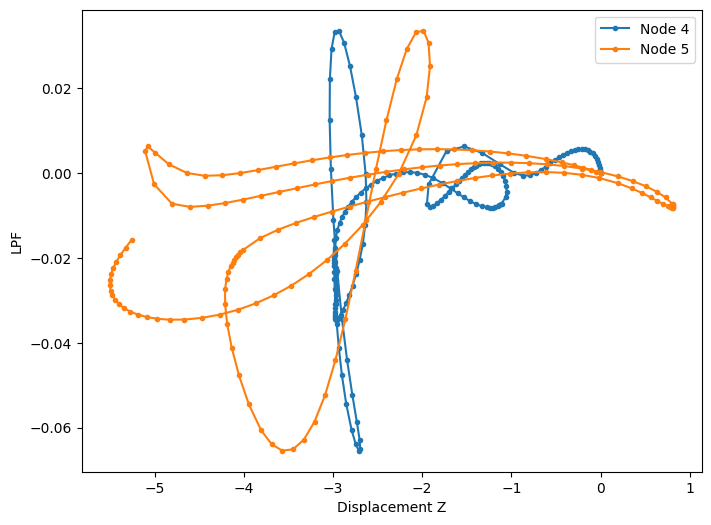

In [36]:
Disp = "Displacement Z"
fig, ax = M.plot_history(nodes=[4, 4], X=Disp, Y="LPF")
fig, ax = M.plot_history(nodes=[5, 5], X=Disp, Y="LPF", fig=fig, ax=ax)
fig.savefig("history_node45_Disp" + Disp[-1] + "-LPF.pdf")
fig.savefig("history_node45_Disp" + Disp[-1] + "-LPF.png")